# Case Examples

##### Import Statements

In [ ]:
import osmnx as ox
print(ox.__version__)


In [17]:
!pip install contextily

  Using cached contextily-1.6.2-py3-none-any.whl (17 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
  Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)


You should consider upgrading via the 'C:\Users\vicen\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [18]:
import evacnx as ex
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
import contextily as cx
import time as time
import numpy as np

## Case 1: Lyons, Colorado

### Evacuation Plans

#### Initial Evacuation Plan

In [ ]:
location = 'Lyons Colorado'
sup_dem_nodes = [(1,-4000),(30,4000),(4,-4000),(40,4000)]
G = ex.construct_orig_graph(location,sup_dem_nodes)
fire_origin_radii = [(40.227510,-105.263519,0.15),(40.231862,-105.266485,0.15),(40.228941,-105.264405,0.15),(40.233535,-105.262882,0.07)]
# fire_origin_radii = [(40.227381,-105.261359,0.05),(40.231862,-105.266485,0.09),(40.228941,-105.264405,0.09),(40.233535,-105.262882,0.07)]

num_time_ints, max_flow, flow_dict, ten_s_t_flow, ten_s_t, rmvd_nodes_mat, edge_dist_mat, fire_poly_mat, max_T = ex.det_num_int(G, 1000, fire_origin_radii)
print('Number of Time Intervals:',num_time_ints)
print('Flow Value:', max_flow)

#### Update to Evaucation Plan

In [ ]:
time_int_update = 4
fire_time_int = 11
fire_origin_radii_update = [(40.227510,-105.263519,0.3),(40.231862,-105.266485,0.2),(40.228941,-105.264405,0.2),(40.233535,-105.262882,0.11)]
# fire_origin_radii_update = [(40.227381,-105.261359,0.1),(40.231862,-105.266485,0.14),(40.228941,-105.264405,0.2),(40.233535,-105.262882,0.11)]
part_ten_s_t, rmvd_nodes_mat_update, edge_dist_mat_update, fire_mat_poly_update, flow_dict_part, flow_value_part, T = ex.evac_update(ten_s_t, G, 
                                                                                  rmvd_nodes_mat, edge_dist_mat, fire_poly_mat, time_int_update, 
                                                                                  fire_time_int, num_time_ints, fire_origin_radii_update, 
                                                                                  flow_dict, pop = 1000, max_T = max_T)

flow_dict_copy = flow_dict.copy()
flow_dict_part_copy = flow_dict_part.copy()
del flow_dict_part_copy[0]
merged_dicts = ex.merge_flow_dicts(flow_dict_copy, flow_dict_part_copy)

merged_tens = ex.merg_tens(ten_s_t.copy(), part_ten_s_t.copy())
colored_max_flow_ten_merg = ex.color_max_flow(merged_tens.copy(),merged_dicts)    

### Plotting

In [ ]:
start_time_int = 15
end_time_int = 24
interval = False
orig_graph = G

##### for orignal evac plan plots
fire = fire_poly_mat
flow_graph = ten_s_t_flow

##### for updated evac plan plots
# fire = fire_mat_poly_update
# flow_graph = colored_max_flow_ten_merg

####get data for plotting
orig_nodes_len =len(orig_graph.nodes)
flow_edges = [(x[0],x[1]) for x in flow_graph.edges(data = True) if flow_graph[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])
orig_flow_edges = ex.flow_at_time_int(flow_graph, flow_edges, orig_graph, end_time_int+1,start_time_int = start_time_int, interval = interval)
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in orig_graph.nodes(data=True)]
size =[ 130 if y['sup_dem'] != 0 else 15 for x,y in orig_graph.nodes(data=True)]

####transform orignal graph data for plotting purposes
gdf_nodes = ox.graph_to_gdfs(orig_graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
orig_crs = gdf_nodes.crs 
gwm_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_edges = ox.graph_to_gdfs(orig_graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
gwm_edges = gdf_edges.to_crs(epsg=3857)

####plot everything
fig, ax= plt.subplots(figsize=(10, 10))
#### use to zoom in on certain areas of plot
# ax.set_xlim(-11718700, -11718000)  # Set x-axis limits
# ax.set_ylim(4898100, 4898600)

gwm_edges.plot(figsize=(10, 10), alpha=1, edgecolor = 'k',ax = ax)

for edge in orig_flow_edges:
    gdf_selected_edge = gwm_edges[gwm_edges.index.isin([edge])]
    gdf_selected_edge.plot(ax=ax, color='#009E73', linewidth=5)

if fire[end_time_int].geom_type == 'Polygon':
    ext = gpd.GeoSeries(fire[end_time_int])
    ext.crs = orig_crs
    gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
    x,y = Polygon(gdf['geometry'].iloc[0]).exterior.xy
    ax.fill(x,y,'#E69F00', alpha = 0.5)
else:
    for geom in fire[end_time_int].geoms:  
        ext = gpd.GeoSeries(geom)
        ext.crs = orig_crs
        gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
        xs, ys = Polygon(gdf['geometry'].iloc[0]).exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#E69F00', ec='none')


gwm_nodes.plot(figsize=(10, 10), alpha=1, color = [sup_dem_colors[node] for node in gwm_nodes.index], 
               markersize = [size[node] for node in gwm_nodes.index] ,ax=ax)
#### add base map as background
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)

ax.axis('off')
# plt.savefig('lyons_updated_plan_12.png')
plt.show()

## Case 2: Butte County, California

### Evacuations

#### Initial Evacuation Plan

In [ ]:
location_2 = 'Butte County California'
sup_dem_nodes_2 = [(800,-500),(4650,-1000),(4060,900),(4050,600)]
G_2= ex.construct_orig_graph(location_2,sup_dem_nodes_2,tolerance = 50,verbose = True)
fire_origin_radii_2 = [(39.775921, -121.563875, 0.2)]

num_time_ints_2, max_flow_2, flow_dict_2, ten_s_t_flow_2_butte, ten_s_t_2, rmvd_nodes_mat_2, edge_dist_mat_2, fire_poly_mat_2_butte, max_T_2 = ex.det_num_int(G_2, 1000, fire_origin_radii_2)
print('Number of Time Intervals:',num_time_ints_2)
print('Flow Value:', max_flow_2)

In [ ]:
location_2 = 'Paradise California'
sup_dem_nodes_2 = [(262,-500),(549,-1000),(520,900),(512,600)]
G_2= ex.construct_orig_graph(location_2,sup_dem_nodes_2,tolerance = 50)
fire_origin_radii_2 = [(39.775921, -121.563875, 0.2)]

num_time_ints_2, max_flow_2, flow_dict_2, ten_s_t_flow_2, ten_s_t_2, rmvd_nodes_mat_2, edge_dist_mat_2, fire_poly_mat_2, max_T_2 = ex.det_num_int(G_2, 1000, fire_origin_radii_2, T = 54)
print('Number of Time Intervals:',num_time_ints_2)
print('Flow Value:', max_flow_2)

#### Updated Evacuation Plan

In [ ]:
time_int_update_2 = 5
fire_time_int_2 = 10
fire_origin_radii_update_2 = [(39.775921, -121.563875, 0.4), (39.767279, -121.559069, 0.85)]
part_ten_s_t_2, rmvd_nodes_mat_update_2, edge_dist_mat_update_2, fire_mat_poly_update_2, flow_dict_part_2, flow_value_part_2, T_2 = ex.evac_update(ten_s_t_2, G_2, 
                                                                                  rmvd_nodes_mat_2, edge_dist_mat_2, fire_poly_mat_2, time_int_update_2, 
                                                                                  fire_time_int_2, num_time_ints_2, fire_origin_radii_update_2, 
                                                                                  flow_dict_2, pop = 1000, max_T = max_T_2)

flow_dict_copy_2 = flow_dict_2.copy()
flow_dict_part_copy_2 = flow_dict_part_2.copy()
del flow_dict_part_copy_2[0]
merged_dicts_2 = ex.merge_flow_dicts(flow_dict_copy_2, flow_dict_part_copy_2)

merged_tens_2 = ex.merg_tens(ten_s_t_2.copy(), part_ten_s_t_2.copy())
colored_max_flow_ten_merg_2 = ex.color_max_flow(merged_tens_2.copy(),merged_dicts_2)

### Plotting

In [ ]:
start_time_int = 0
end_time_int = 53
interval = True
orig_graph = G_2

##### for orignal evac plan plots
fire = fire_poly_mat_2
flow_graph = ten_s_t_flow_2

##### for updated evac plan plots
# fire = fire_mat_poly_update_2
# flow_graph = colored_max_flow_ten_merg_2

####get data for plotting
orig_nodes_len =len(orig_graph.nodes)
flow_edges = [(x[0],x[1]) for x in flow_graph.edges(data = True) if flow_graph[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])
orig_flow_edges = ex.flow_at_time_int(flow_graph, flow_edges, orig_graph, end_time_int+1,start_time_int = start_time_int, interval = interval)
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in orig_graph.nodes(data=True)]
size =[ 70 if y['sup_dem'] != 0 else 2 for x,y in orig_graph.nodes(data=True)]

####transform orignal graph data for plotting purposes
gdf_nodes = ox.graph_to_gdfs(orig_graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
orig_crs = gdf_nodes.crs 
gwm_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_edges = ox.graph_to_gdfs(orig_graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
gwm_edges = gdf_edges.to_crs(epsg=3857)

####plot everything
fig, ax= plt.subplots(figsize=(10, 10))
####used to zoom in on area of plot
# ax.set_xlim(-13540000, -13527500)  # Set x-axis limits
# ax.set_ylim(4825500, 4837000)  # Set y-axis limits

gwm_edges.plot(alpha=1, edgecolor = 'k', ax = ax, zorder = 2)

for edge in orig_flow_edges:
    gdf_selected_edge = gwm_edges[gwm_edges.index.isin([edge])]
    gdf_selected_edge.plot(ax=ax, color='#009E73', linewidth=4, zorder = 5)

if fire[end_time_int].geom_type == 'Polygon':
    ext = gpd.GeoSeries(fire[end_time_int])
    ext.crs = orig_crs
    gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
    x,y = Polygon(gdf['geometry'].iloc[0]).exterior.xy
    ax.fill(x,y,'#E69F00', alpha = 0.5, zorder = 5)
else:
    for geom in fire[end_time_int].geoms:  
        ext = gpd.GeoSeries(geom)
        ext.crs = orig_crs
        gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
        xs, ys = Polygon(gdf['geometry'].iloc[0]).exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#E69F00', ec='none', zorder = 5)


gwm_nodes.plot(figsize=(10, 10), alpha=1, color = [sup_dem_colors[node] for node in gwm_nodes.index], 
               markersize = [size[node] for node in gwm_nodes.index] ,ax=ax, zorder = 3)
#### add map to background
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, zorder = 1)

ax.axis('off')
# plt.savefig('paradise_updated_t_11.png')
plt.show()

## Case 3: Alexandroupolis Greece

### Evacuations

#### Initial Evacuation Plan

In [ ]:
location_3 = ox.geocode_to_gdf("Alexandroupolis Greece")
# sup_dem_nodes_3 = [(1056,1500),(1095,2500),(1078,1000),(10,-5000)]
sup_dem_nodes_3 = [(1013,1500),(1042,2500),(1031,1000),(10,-5000)] ## dist = 2000
G_3 = ex.construct_orig_graph(location_3,sup_dem_nodes_3,distance = 2000)
fire_origin_radii_3 = [(40.864346, 25.863716, 0.1), (40.857190, 25.881404, 0.06), (40.862659, 25.862857,0.06), (40.863632,25.857021,0.09)]
# fire_origin_radii_3 = [(40.864346, 25.863716, 0.1), (40.864801, 25.859081, 0.1), (40.862659, 25.862857,0.06), (40.863632,25.857021,0.09)]

num_time_ints_3, max_flow_3, flow_dict_3, ten_s_t_flow_3, ten_s_t_3, rmvd_nodes_mat_3, edge_dist_mat_3, fire_poly_mat_3, max_T_3 = ex.det_num_int(G_3, 1000, fire_origin_radii_3)
print('Number of Time Intervals:',num_time_ints_3)
print('Flow Value:', max_flow_3)

#### Updated Evacuation Plan

In [ ]:
### 2 Updates
time_ints_3 = [5,20]
fire_times_3 = [10,25]
fires = [[(40.864346, 25.863716, 0.25), (40.857190, 25.881404, 0.12), (40.862659, 25.862857,0.2), (40.863632,25.857021,0.25), (40.854630, 25.896757, 0.06)],
         [(40.864346, 25.863716, 0.3), (40.857190, 25.881404, 0.18), (40.862659, 25.862857,0.25), (40.863632,25.857021,0.35), (40.854630, 25.896757, 0.12)]]
nodes_mat = rmvd_nodes_mat_3.copy()
edges_mat = edge_dist_mat_3.copy()
fire_mat = fire_poly_mat_3.copy()
orig_net = ten_s_t_3.copy()
flow = flow_dict_3.copy()
for i in range(len(time_ints_3)):
    time_int_update_3 = time_ints_3[i]
    fire_time_int_3 = fire_times_3[i]
    fire_origin_radii_update_3 = fires[i]
    part_ten_s_t_3, rmvd_nodes_mat_update_3, edge_dist_mat_update_3, fire_mat_poly_update_3, flow_dict_part_3, flow_value_part_3, T_3 = ex.evac_update(orig_net,
                                                                                          G_3, nodes_mat, edges_mat, fire_mat,
                                                                                          time_int_update_3, fire_time_int_3, num_time_ints_3, 
                                                                                          fire_origin_radii_update_3, flow, pop = 1000, max_T = max_T_3)

    print(flow_value_part_3)

    flow_dict_copy_3 = flow_dict_3.copy()
    flow_dict_part_copy_3 = flow_dict_part_3.copy()
    del flow_dict_part_copy_3[0]
    merged_dicts_3 = ex.merge_flow_dicts(flow_dict_copy_3, flow_dict_part_copy_3)
    flow = merged_dicts_3.copy()

    merged_tens_3 = ex.merg_tens(orig_net.copy(), part_ten_s_t_3.copy())
    
    orig_net = merged_tens_3.copy()
    nodes_mat = rmvd_nodes_mat_update_3.copy()
    edges_mat = edge_dist_mat_update_3.copy()
    fire_mat = fire_mat_poly_update_3.copy()
    end = time.time()

colored_max_flow_ten_merg_3 = ex.color_max_flow(orig_net.copy(),flow)

### Plotting

In [ ]:
start_time_int = 0
end_time_int = 41
interval = True
orig_graph = G_3

##### for orignal evac plan plots
# fire = fire_poly_mat_3
# flow_graph = ten_s_t_flow_3

##### for updated evac plan plots
fire = fire_mat_poly_update_3
flow_graph = colored_max_flow_ten_merg_3

####get data for plotting
orig_nodes_len =len(orig_graph.nodes)
flow_edges = [(x[0],x[1]) for x in flow_graph.edges(data = True) if flow_graph[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])
orig_flow_edges = ex.flow_at_time_int(flow_graph, flow_edges, orig_graph, end_time_int+1, start_time_int = start_time_int, interval = interval)
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in orig_graph.nodes(data=True)]
size =[ 70 if y['sup_dem'] != 0 else 2 for x,y in orig_graph.nodes(data=True)]


####transform orignal graph data for plotting purposes
gdf_nodes = ox.graph_to_gdfs(orig_graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
orig_crs = gdf_nodes.crs 
gwm_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_edges = ox.graph_to_gdfs(orig_graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
gwm_edges = gdf_edges.to_crs(epsg=3857)

####plot everything
fig, ax= plt.subplots(figsize=(10, 10))
### use to zoom in on aprt of plot
# ax.set_xlim(2883000, 2885000)  # Set x-axis limits
# ax.set_ylim(4994250, 4995800)  # Set y-axis limits

gwm_edges.plot(figsize=(10, 10), alpha=1, edgecolor = 'k',linewidth = 2, ax = ax)

for edge in orig_flow_edges:
    gdf_selected_edge = gwm_edges[gwm_edges.index.isin([edge])]
    gdf_selected_edge.plot(ax=ax, color='#009E73', linewidth=4)

if fire[end_time_int].geom_type == 'Polygon':
    ext = gpd.GeoSeries(fire[end_time_int])
    ext.crs = orig_crs
    gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
    x,y = Polygon(gdf['geometry'].iloc[0]).exterior.xy
    ax.fill(x,y,'#E69F00', alpha = 0.5)
else:
    for geom in fire[end_time_int].geoms:  
        ext = gpd.GeoSeries(geom)
        ext.crs = orig_crs
        gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
        xs, ys = Polygon(gdf['geometry'].iloc[0]).exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#E69F00', ec='none')


gwm_nodes.plot(figsize=(10, 10), alpha=1, color = [sup_dem_colors[node] for node in gwm_nodes.index], 
               markersize = [size[node] for node in gwm_nodes.index] ,ax=ax)
#### map as background
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)

ax.axis('off')
# plt.savefig('greece_updated_plan_2.png')
plt.show()

# Caso de prueba area de estudio

### Evacuation Plans

In [ ]:
# sup_dem_nodes_3 = [(1056,1500),(1095,2500),(1078,1000),(10,-5000)]
sup_dem_nodes_4 = [(105,1500),(42,2500),(31,1000),(10,-5000)] ## Se eligen los nodos de fuentes (a evacuar) y sumidero (lugar para la evacuación), en este caso como se ti
G_4 = ex.construct_orig_graph(location_4,sup_dem_nodes_4,distance = 2000)
fire_origin_radii_4 = [(-37.671496, -72.5650675, 0.1), (-37.671496, -72.476378, 0.06)]
# fire_origin_radii_3 = [(40.864346, 25.863716, 0.1), (40.864801, 25.859081, 0.1), (40.862659, 25.862857,0.06), (40.863632,25.857021,0.09)]

num_time_ints_4, max_flow_4, flow_dict_4, ten_s_t_flow_4, ten_s_t_4, rmvd_nodes_mat_4, edge_dist_mat_4, fire_poly_mat_4, max_T_4 = ex.det_num_int(G_4, 1000, fire_origin_radii_4)
print('Number of Time Intervals:',num_time_ints_4)
print('Flow Value:', max_flow_4)

#### Updated Evacuation Plan

In [ ]:
### 2 Updates
time_ints_4 = [1,15]
fire_times_4 = [8,17]
fires = [[(-37.59, -72.52, 0.4)],
         [(-37.59, -72.52, 0.5)]]
nodes_mat = rmvd_nodes_mat_4.copy()
edges_mat = edge_dist_mat_4.copy()
fire_mat = fire_poly_mat_4.copy()
orig_net = ten_s_t_4.copy()
flow = flow_dict_4.copy()
for i in range(len(time_ints_4)):
    time_int_update_4 = time_ints_4[i]
    fire_time_int_4 = fire_times_4[i]
    fire_origin_radii_update_4 = fires[i]
    part_ten_s_t_4, rmvd_nodes_mat_update_4, edge_dist_mat_update_4, fire_mat_poly_update_4, flow_dict_part_4, flow_value_part_4, T_4 = ex.evac_update(orig_net,
                                                                                          G_4, nodes_mat, edges_mat, fire_mat,
                                                                                          time_int_update_4, fire_time_int_4, num_time_ints_4, 
                                                                                          fire_origin_radii_update_4, flow, pop = 1000, max_T = max_T_4)

    print(flow_value_part_4)

    flow_dict_copy_4 = flow_dict_4.copy()
    flow_dict_part_copy_4 = flow_dict_part_4.copy()
    del flow_dict_part_copy_4[0]
    merged_dicts_4 = ex.merge_flow_dicts(flow_dict_copy_4, flow_dict_part_copy_4)
    flow = merged_dicts_4.copy()

    merged_tens_4 = ex.merg_tens(orig_net.copy(), part_ten_s_t_4.copy())
    
    orig_net = merged_tens_4.copy()
    nodes_mat = rmvd_nodes_mat_update_4.copy()
    edges_mat = edge_dist_mat_update_4.copy()
    fire_mat = fire_mat_poly_update_4.copy()
    end = time.time()

colored_max_flow_ten_merg_4 = ex.color_max_flow(orig_net.copy(),flow)

### Plotting

In [ ]:
start_time_int = 0
end_time_int = 17
interval = True
orig_graph = G_4

##### for orignal evac plan plots
# fire = fire_poly_mat_3
# flow_graph = ten_s_t_flow_3

##### for updated evac plan plots
fire = fire_mat_poly_update_4
flow_graph = colored_max_flow_ten_merg_4

####get data for plotting
orig_nodes_len =len(orig_graph.nodes)
flow_edges = [(x[0],x[1]) for x in flow_graph.edges(data = True) if flow_graph[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])
orig_flow_edges = ex.flow_at_time_int(flow_graph, flow_edges, orig_graph, end_time_int+1, start_time_int = start_time_int, interval = interval)
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in orig_graph.nodes(data=True)]
size =[ 70 if y['sup_dem'] != 0 else 2 for x,y in orig_graph.nodes(data=True)]


####transform orignal graph data for plotting purposes
gdf_nodes = ox.graph_to_gdfs(orig_graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
orig_crs = gdf_nodes.crs 
gwm_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_edges = ox.graph_to_gdfs(orig_graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
gwm_edges = gdf_edges.to_crs(epsg=3857)

####plot everything
fig, ax= plt.subplots(figsize=(10, 10))
### use to zoom in on aprt of plot
# ax.set_xlim(2883000, 2885000)  # Set x-axis limits
# ax.set_ylim(4994250, 4995800)  # Set y-axis limits

gwm_edges.plot(figsize=(10, 10), alpha=1, edgecolor = 'k',linewidth = 2, ax = ax)

for edge in orig_flow_edges:
    gdf_selected_edge = gwm_edges[gwm_edges.index.isin([edge])]
    gdf_selected_edge.plot(ax=ax, color='#009E73', linewidth=4)

if fire[end_time_int].geom_type == 'Polygon':
    ext = gpd.GeoSeries(fire[end_time_int])
    ext.crs = orig_crs
    gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
    x,y = Polygon(gdf['geometry'].iloc[0]).exterior.xy
    ax.fill(x,y,'#E69F00', alpha = 0.5)
else:
    for geom in fire[end_time_int].geoms:  
        ext = gpd.GeoSeries(geom)
        ext.crs = orig_crs
        gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
        xs, ys = Polygon(gdf['geometry'].iloc[0]).exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#E69F00', ec='none')


gwm_nodes.plot(figsize=(10, 10), alpha=1, color = [sup_dem_colors[node] for node in gwm_nodes.index], 
               markersize = [size[node] for node in gwm_nodes.index] ,ax=ax)
#### map as background
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)

ax.axis('off')
# plt.savefig('greece_updated_plan_2.png')
plt.show()

In [ ]:
start_time_int = 0
end_time_int = 30
interval = True
orig_graph = G_3

##### for orignal evac plan plots
fire = fire_poly_mat_3
flow_graph = ten_s_t_flow_3

##### for updated evac plan plots
# fire = fire_mat_poly_update_4
# flow_graph = colored_max_flow_ten_merg_4

####get data for plotting
orig_nodes_len =len(orig_graph.nodes)
flow_edges = [(x[0],x[1]) for x in flow_graph.edges(data = True) if flow_graph[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])
orig_flow_edges = ex.flow_at_time_int(flow_graph, flow_edges, orig_graph, end_time_int+1, start_time_int = start_time_int, interval = interval)
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in orig_graph.nodes(data=True)]
size =[ 70 if y['sup_dem'] != 0 else 2 for x,y in orig_graph.nodes(data=True)]


####transform orignal graph data for plotting purposes
gdf_nodes = ox.graph_to_gdfs(orig_graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
orig_crs = gdf_nodes.crs 
gwm_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_edges = ox.graph_to_gdfs(orig_graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
gwm_edges = gdf_edges.to_crs(epsg=3857)

####plot everything
fig, ax= plt.subplots(figsize=(10, 10))
### use to zoom in on aprt of plot
# ax.set_xlim(2883000, 2885000)  # Set x-axis limits
# ax.set_ylim(4994250, 4995800)  # Set y-axis limits

gwm_edges.plot(figsize=(10, 10), alpha=1, edgecolor = 'k',linewidth = 2, ax = ax)

for edge in orig_flow_edges:
    gdf_selected_edge = gwm_edges[gwm_edges.index.isin([edge])]
    gdf_selected_edge.plot(ax=ax, color='#009E73', linewidth=4)

if fire[end_time_int].geom_type == 'Polygon':
    ext = gpd.GeoSeries(fire[end_time_int])
    ext.crs = orig_crs
    gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
    x,y = Polygon(gdf['geometry'].iloc[0]).exterior.xy
    ax.fill(x,y,'#E69F00', alpha = 0.5)
else:
    for geom in fire[end_time_int].geoms:  
        ext = gpd.GeoSeries(geom)
        ext.crs = orig_crs
        gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
        xs, ys = Polygon(gdf['geometry'].iloc[0]).exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#E69F00', ec='none')


gwm_nodes.plot(figsize=(10, 10), alpha=1, color = [sup_dem_colors[node] for node in gwm_nodes.index], 
               markersize = [size[node] for node in gwm_nodes.index] ,ax=ax)
#### map as background
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)

ax.axis('off')
# plt.savefig('greece_updated_plan_2.png')
plt.show()

## Caso de prueba 2

In [19]:
    location_a = ox.geocode_to_gdf("Nacimiento, Chile") # String de la zona geográfica
location_a

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-73.07108 -37.62006, -73.07057 -37.6...",-73.071075,-37.629911,-72.594936,-37.27547,632885,relation,1632643,-37.501829,-72.67311,boundary,administrative,16,0.427796,town,Nacimiento,"Nacimiento, Provincia de Bío-Bío, Biobio Regio..."


### Evacuation plans

In [20]:
# sup_dem_nodes_3 = [(1056,1500),(1095,2500),(1078,1000),(10,-5000)]
sup_dem_nodes_a = [(101, 65), (245, 5286), (174, 5463), (637, 2324), (49, 4786), (211, 891), (562, 6359), (171, 1100),(0,-26274)] ## dist = 2000
G_a = ex.construct_orig_graph(location_a,sup_dem_nodes_a,distance = 2000)
fire_origin_radii_a = [(-37.49086, -72.6824, 0.45)]
# fire_origin_radii_3 = [(40.864346, 25.863716, 0.1), (40.864801, 25.859081, 0.1), (40.862659, 25.862857,0.06), (40.863632,25.857021,0.09)]

num_time_ints_a, max_flow_a, flow_dict_a, ten_s_t_flow_a, ten_s_t_a, rmvd_nodes_mat_a, edge_dist_mat_a, fire_poly_mat_a, max_T_a = ex.det_num_int(G_a, 1000, fire_origin_radii_a)
print('Number of Time Intervals:',num_time_ints_a)
print('Flow Value:', max_flow_a)

Number of Time Intervals: 32
Flow Value: 26274.0


#### Updated Evacuation Plan

In [69]:
### 2 Updates
time_ints_a = [1,24]
fire_times_a = [8,12]
fires = [[(-37.5036, -72.6774, 0.4)],
         [(-37.5036, -72.6774, 0.5)]]
nodes_mat = rmvd_nodes_mat_a.copy()
edges_mat = edge_dist_mat_a.copy()
fire_mat = fire_poly_mat_a.copy()
orig_net = ten_s_t_a.copy()
flow = flow_dict_a.copy()
for i in range(len(time_ints_a)):
    time_int_update_a = time_ints_a[i]
    fire_time_int_a = fire_times_a[i]
    fire_origin_radii_update_a = fires[i]
    part_ten_s_t_a, rmvd_nodes_mat_update_a, edge_dist_mat_update_a, fire_mat_poly_update_a, flow_dict_part_a, flow_value_part_a, T_4 = ex.evac_update(orig_net,
                                                                                          G_a, nodes_mat, edges_mat, fire_mat,
                                                                                          time_int_update_a, fire_time_int_a, num_time_ints_a, 
                                                                                          fire_origin_radii_update_a, flow, pop = 1000, max_T = max_T_a)

    print(flow_value_part_a)

    flow_dict_copy_a = flow_dict_a.copy()
    flow_dict_part_copy_a = flow_dict_part_a.copy()
    del flow_dict_part_copy_a[0]
    merged_dicts_a = ex.merge_flow_dicts(flow_dict_copy_a, flow_dict_part_copy_a)
    flow = merged_dicts_a.copy()

    merged_tens_a = ex.merg_tens(orig_net.copy(), part_ten_s_t_a.copy())
    
    orig_net = merged_tens_a.copy()
    nodes_mat = rmvd_nodes_mat_update_a.copy()
    edges_mat = edge_dist_mat_update_a.copy()
    fire_mat = fire_mat_poly_update_a.copy()
    end = time.time()

colored_max_flow_ten_merg_a = ex.color_max_flow(orig_net.copy(),flow)

17804.0
17804.0


### Plotting

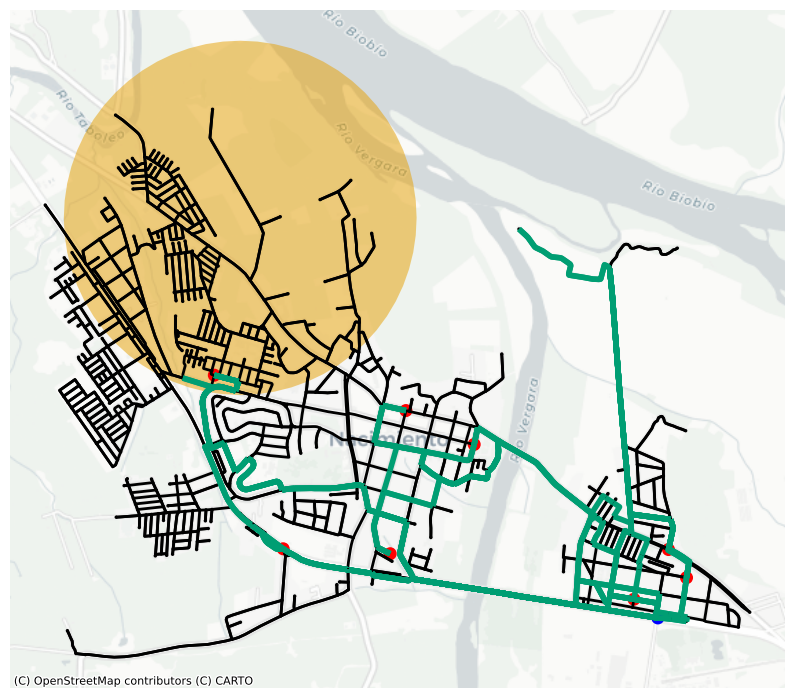

In [21]:
start_time_int = 0
end_time_int = 31
interval = True
orig_graph = G_a

##### for orignal evac plan plots
fire = fire_poly_mat_a
flow_graph = ten_s_t_flow_a

##### for updated evac plan plots
#fire = fire_mat_poly_update_a
#flow_graph = colored_max_flow_ten_merg_a

####get data for plotting
orig_nodes_len =len(orig_graph.nodes)
flow_edges = [(x[0],x[1]) for x in flow_graph.edges(data = True) if flow_graph[x[0]][x[1]]['color'] == (1,0,0)]
flow_edges.sort(key=lambda tup: tup[0])
orig_flow_edges = ex.flow_at_time_int(flow_graph, flow_edges, orig_graph, end_time_int+1, start_time_int = start_time_int, interval = interval)
sup_dem_colors=['blue' if y['sup_dem'] < 0 else 'red' if y['sup_dem'] > 0 else 'black' for x,y in orig_graph.nodes(data=True)]
size =[ 70 if y['sup_dem'] != 0 else 2 for x,y in orig_graph.nodes(data=True)]


####transform orignal graph data for plotting purposes
gdf_nodes = ox.graph_to_gdfs(orig_graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
orig_crs = gdf_nodes.crs 
gwm_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_edges = ox.graph_to_gdfs(orig_graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
gwm_edges = gdf_edges.to_crs(epsg=3857)

####plot everything
fig, ax= plt.subplots(figsize=(10, 10))
### use to zoom in on aprt of plot
# ax.set_xlim(2883000, 2885000)  # Set x-axis limits
# ax.set_ylim(4994250, 4995800)  # Set y-axis limits

gwm_edges.plot(figsize=(10, 10), alpha=1, edgecolor = 'k',linewidth = 2, ax = ax)

for edge in orig_flow_edges:
    gdf_selected_edge = gwm_edges[gwm_edges.index.isin([edge])]
    gdf_selected_edge.plot(ax=ax, color='#009E73', linewidth=4)

if fire[end_time_int].geom_type == 'Polygon':
    ext = gpd.GeoSeries(fire[end_time_int])
    ext.crs = orig_crs
    gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
    x,y = Polygon(gdf['geometry'].iloc[0]).exterior.xy
    ax.fill(x,y,'#E69F00', alpha = 0.5)
else:
    for geom in fire[end_time_int].geoms:  
        ext = gpd.GeoSeries(geom)
        ext.crs = orig_crs
        gdf = gpd.GeoDataFrame(geometry=ext).to_crs(epsg=3857)
        xs, ys = Polygon(gdf['geometry'].iloc[0]).exterior.xy    
        ax.fill(xs, ys, alpha=0.5, fc='#E69F00', ec='none')


gwm_nodes.plot(figsize=(10, 10), alpha=1, color = [sup_dem_colors[node] for node in gwm_nodes.index], 
               markersize = [size[node] for node in gwm_nodes.index] ,ax=ax)
#### map as background
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)

ax.axis('off')
# plt.savefig('greece_updated_plan_2.png')
plt.show()

In [70]:
 ox.graph_from_place("Nacimiento, Chile", network_type="drive")